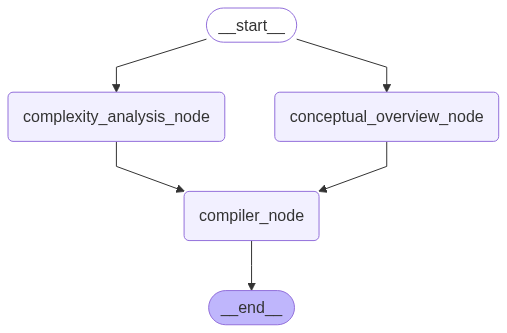

In [1]:
import os
from typing import TypedDict

from IPython.display import Image, Markdown
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import END, START, StateGraph


class AgentState(TypedDict):
    question: str
    conceptual_overview: str
    complexity_analysis: str
    response: str


llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")


async def conceptual_overview_node(state: AgentState):
    prompt_template = f"""
As an expert programming tutor, explain the core concept of the LeetCode problem below in a simple, "Explain Like I'm 5" style. 
Your main goal is to provide a mental model or real-world analogy that helps user discover an efficient solution on their own. Hint at the key insight or trade-off needed, but do not name any specific algorithm or data structure.
Do not write or reference any code.
Problem:
{state["question"]}
"""
    response = await llm.ainvoke(prompt_template)
    return {"conceptual_overview": response.content}


async def complexity_analysis_node(state: AgentState):
    prompt_template = f"""
As a senior engineer, intuitively explain the time and space complexity for an optimal solution to the LeetCode problem below. 
Explain *why* the runtime is what it is. Focus on how the number of operations grows as the input size increases. For example, does the solution need to process each piece of the input just once, or multiple times?
Explain *why* extra memory might be needed. Describe what information needs to be stored and how its size relates to the original input.
Do not write or reference any code.
Problem:
{state["question"]}
"""
    response = await llm.ainvoke(prompt_template)
    return {"complexity_analysis": response.content}


def compiler_node(state: AgentState):
    conceptual_overview = state.get("conceptual_overview", "No overview generated.")
    complexity_analysis = state.get(
        "complexity_analysis", "No complexity analysis generated."
    )
    report = f"""## LeetCode Problem Analysis

### Conceptual Overview
{conceptual_overview}
### Complexity Analysis
{complexity_analysis}
"""
    return {"response": report}


builder = StateGraph(AgentState)
builder.add_node("conceptual_overview_node", conceptual_overview_node)
builder.add_node("complexity_analysis_node", complexity_analysis_node)
builder.add_node("compiler_node", compiler_node)

builder.add_edge(START, "conceptual_overview_node")
builder.add_edge(START, "complexity_analysis_node")
builder.add_edge("conceptual_overview_node", "compiler_node")
builder.add_edge("complexity_analysis_node", "compiler_node")
builder.add_edge("compiler_node", END)

graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())

In [2]:
question = "Explain Leetcode 1. Two Sum"
result = await graph.ainvoke({"question": question})

Markdown(result["response"])

## LeetCode Problem Analysis

### Conceptual Overview
Imagine you have a box of LEGO bricks, each with a number written on it.  You need to find two specific bricks that, when you add their numbers together, equal a target number.

You could try picking up every single brick and checking it against *every other* brick – that would work, but it would take a long, long time if you have lots of bricks!

Think about a smarter way.  What if you had a special notebook where you wrote down which bricks you've already seen and what their numbers were? Then, when you pick up a brick, you can quickly check your notebook to see if there's a brick that would make the target number when added to the brick in your hand.

The key is finding a way to remember the bricks you've already seen *efficiently*, so you don't have to do so much searching. There's a trade-off: using more memory (the notebook) to save a lot of time.
### Complexity Analysis
LeetCode problem 1, "Two Sum," seeks two numbers within an array that add up to a target value.  An optimal solution achieves O(n) time complexity and O(n) space complexity.

**Time Complexity: O(n)**

The optimal solution achieves linear time because it processes each element in the input array (of size 'n') effectively only once.  A hash table (or similar data structure like a dictionary) is used.  For each number encountered, we check if its *complement* (target - number) already exists in the hash table.  If it does, we've found our pair. If not, we add the current number and its index to the hash table.  This lookup and insertion in a hash table takes, on average, constant time O(1). Since we iterate through the array once performing a constant-time operation for each element, the overall time complexity is directly proportional to the input size 'n', hence O(n).  We don't revisit any elements; each is considered only once.


**Space Complexity: O(n)**

The space complexity is linear because, in the worst-case scenario, we might need to store every number from the input array in the hash table.  The hash table's size is directly proportional to the input array's size.   Each entry in the hash table stores at least the number itself (and potentially its index). Therefore, the space required grows linearly with the input size 'n', leading to O(n) space complexity.  If the input array contained unique numbers, the hash table would need to store all 'n' numbers.  In some exceptional cases with many duplicates, it might be smaller, but it's still bounded by O(n) in the worst case.
